<a href="https://colab.research.google.com/github/rootofdata/Outlier_Detection/blob/main/Main_Paper_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised outlier detection for Time series data using LSTM + AE
Feature : TMP,HMD,TVOC,CO,CO2,CH2O,PM10 (7 features)   
Time : 2022-04-01 ~ 2022-05-16

## 0. Setting

### 구글코랩 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Outlier Detection Paper'

/content/drive/.shortcut-targets-by-id/1S9I6ATEci1ZBNpMlPkK6JfcQv0DBJcM9/Outlier Detection Paper


In [ ]:
!ls

 영석	      data		 'Jun Hyeok3.ipynb'  'Main Paper Code.ipynb'
'논문 작업'  'Jun Hyeok2.ipynb'  'Jun Hyeok.ipynb'    Reference


### 필요한 라이브러리 호출

In [ ]:
from glob import glob
import os

import pandas as pd
import numpy as np
import datetime
import time

import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family']='Malgun Gothic'  # 한글 폰트 패치.
matplotlib.rcParams['axes.unicode_minus'] = False   

import warnings
warnings.filterwarnings('ignore')   # 경고문 처리.

from sklearn.preprocessing import StandardScaler

## 1. Data Load

### User Function Definition

In [ ]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols):
  df = data[cols]
  plt.figure(figsize=(20,10))
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

### Device 11

In [ ]:
filst = sorted(glob('data/*.csv'))
filst

['data/device11_0401_to_0516.csv', 'data/device16_0401_to_0516.csv']

In [ ]:
device11 = pd.read_csv(filst[0])
device16 = pd.read_csv(filst[1])

In [ ]:
print(device11.shape)
device11.head()

(26858, 17)


,DeviceName,EntityId,TsYMD,CH2O,PM2.5,PM10,TVOC,CO2,Temperature,Humidity,Radioactivity,Sound,CO,Stink,NO2,H2S,NH3
0,Device 10000011,d369b400-144d-11ec-80c8-b1d8e607054f,2022-04-07 10:46:38,36.0,2.0,3.0,1693.0,592.0,23.49,16.35,0.03,35.0,1.06,0.03,0.01,0.0,0.0
1,Device 10000011,d369b400-144d-11ec-80c8-b1d8e607054f,2022-04-07 10:48:38,29.0,1.0,2.0,1675.0,592.0,24.72,16.11,0.00,35.0,0.98,0.03,0.01,0.0,0.0
2,Device 10000011,d369b400-144d-11ec-80c8-b1d8e607054f,2022-04-07 10:50:38,28.0,1.0,1.0,1698.0,597.0,24.73,16.05,0.00,31.0,0.81,0.03,0.01,0.0,0.0
3,Device 10000011,d369b400-144d-11ec-80c8-b1d8e607054f,2022-04-07 10:52:38,28.0,1.0,1.0,1740.0,598.0,24.74,16.02,0.03,38.0,0.96,0.03,0.01,0.0,0.0
4,Device 10000011,d369b400-144d-11ec-80c8-b1d8e607054f,2022-04-07 10:54:38,29.0,1.0,2.0,1754.0,602.0,23.10,16.02,0.05,37.0,0.77,0.03,0.01,0.0,0.0


In [ ]:
device11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26858 entries, 0 to 26857
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     26858 non-null  object 
 1   EntityId       26858 non-null  object 
 2   TsYMD          26858 non-null  object 
 3   CH2O           26858 non-null  float64
 4   PM2.5          26858 non-null  float64
 5   PM10           26858 non-null  float64
 6   TVOC           26858 non-null  float64
 7   CO2            26858 non-null  float64
 8   Temperature    26858 non-null  float64
 9   Humidity       26858 non-null  float64
 10  Radioactivity  26858 non-null  float64
 11  Sound          26858 non-null  float64
 12  CO             26858 non-null  float64
 13  Stink          26858 non-null  float64
 14  NO2            26858 non-null  float64
 15  H2S            26858 non-null  float64
 16  NH3            26858 non-null  float64
dtypes: float64(14), object(3)
memory usage: 3.5+ MB


In [ ]:
device11.describe()

,CH2O,PM2.5,PM10,TVOC,CO2,Temperature,Humidity,Radioactivity,Sound,CO,Stink,NO2,H2S,NH3
count,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.000000,26858.0,26858.0
mean,35.124618,5.687542,9.756460,1810.430412,550.039504,23.562756,19.065201,0.019528,37.923971,0.448039,0.018068,0.006507,0.0,0.0
std,43.783533,5.507792,10.235937,998.464677,124.948390,2.388771,3.654859,0.030341,4.240932,0.344297,0.014783,0.004768,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,400.000000,18.500000,9.660000,0.000000,26.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,21.000000,2.000000,3.000000,1064.000000,453.000000,21.830000,16.710000,0.000000,35.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,27.000000,4.000000,6.000000,1629.000000,539.000000,23.215000,18.560000,0.000000,38.000000,0.580000,0.020000,0.010000,0.0,0.0
75%,36.000000,8.000000,13.000000,2253.000000,619.000000,25.030000,20.700000,0.030000,41.000000,0.710000,0.030000,0.010000,0.0,0.0
max,926.000000,53.000000,99.000000,8440.000000,1924.000000,34.380000,33.130000,0.850000,57.000000,1.680000,0.390000,0.010000,0.0,0.0


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


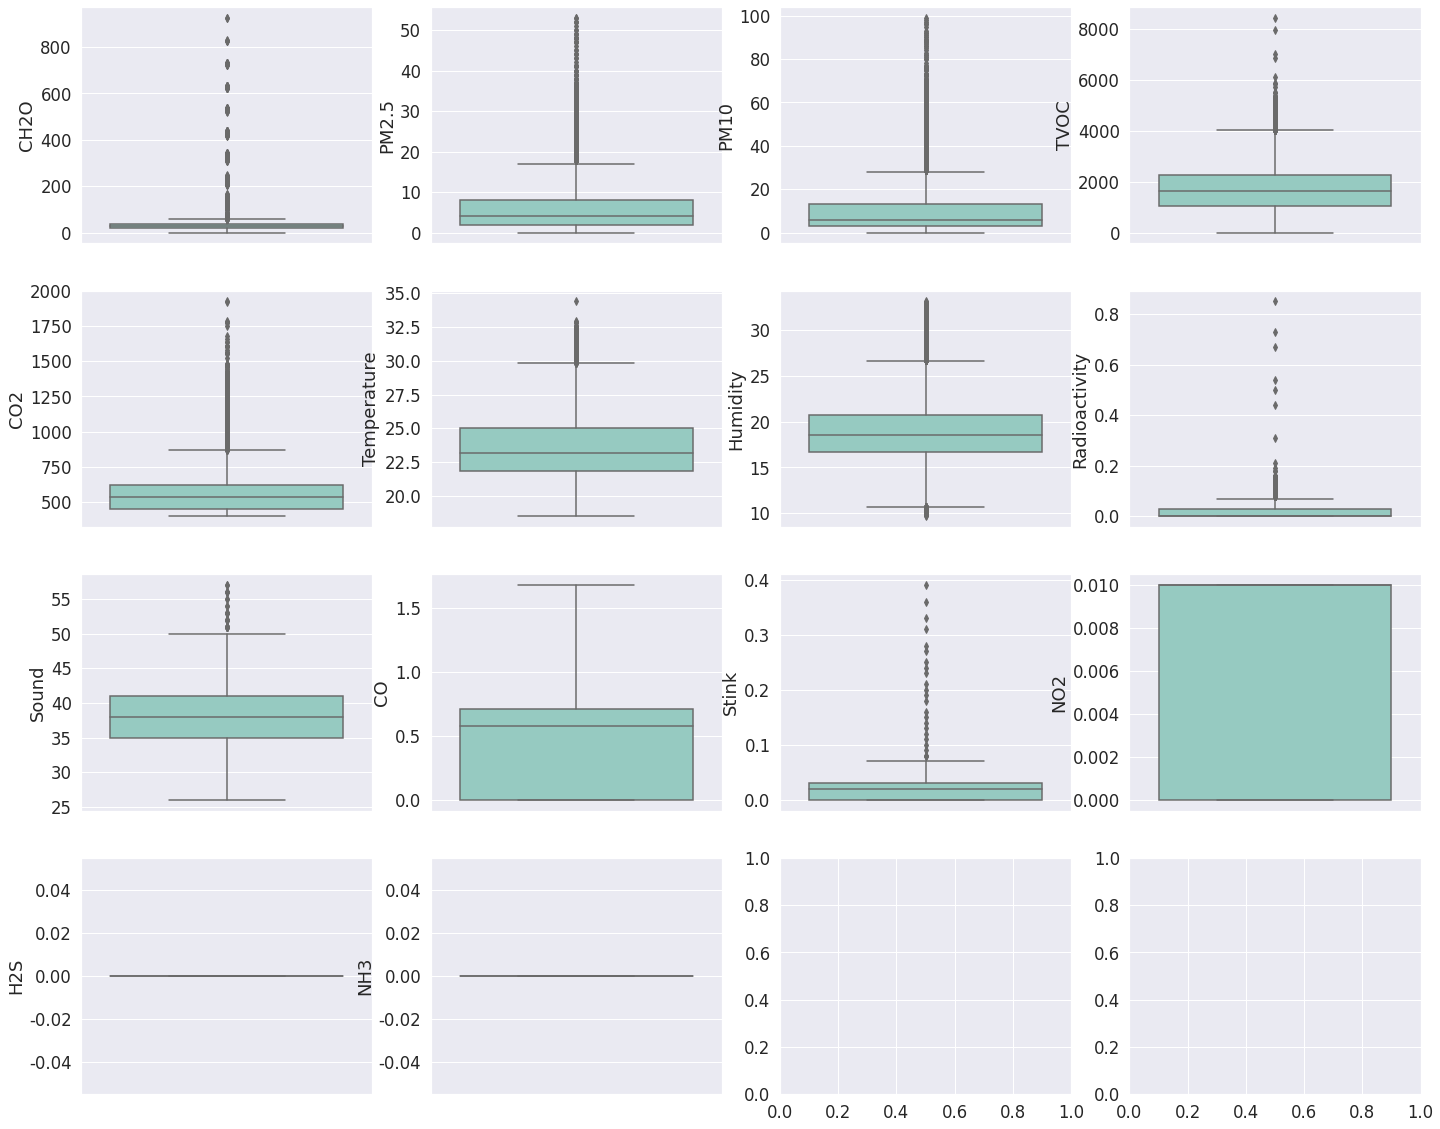

In [ ]:
boxplotEDA(device11,device11.columns[3:],4,4)

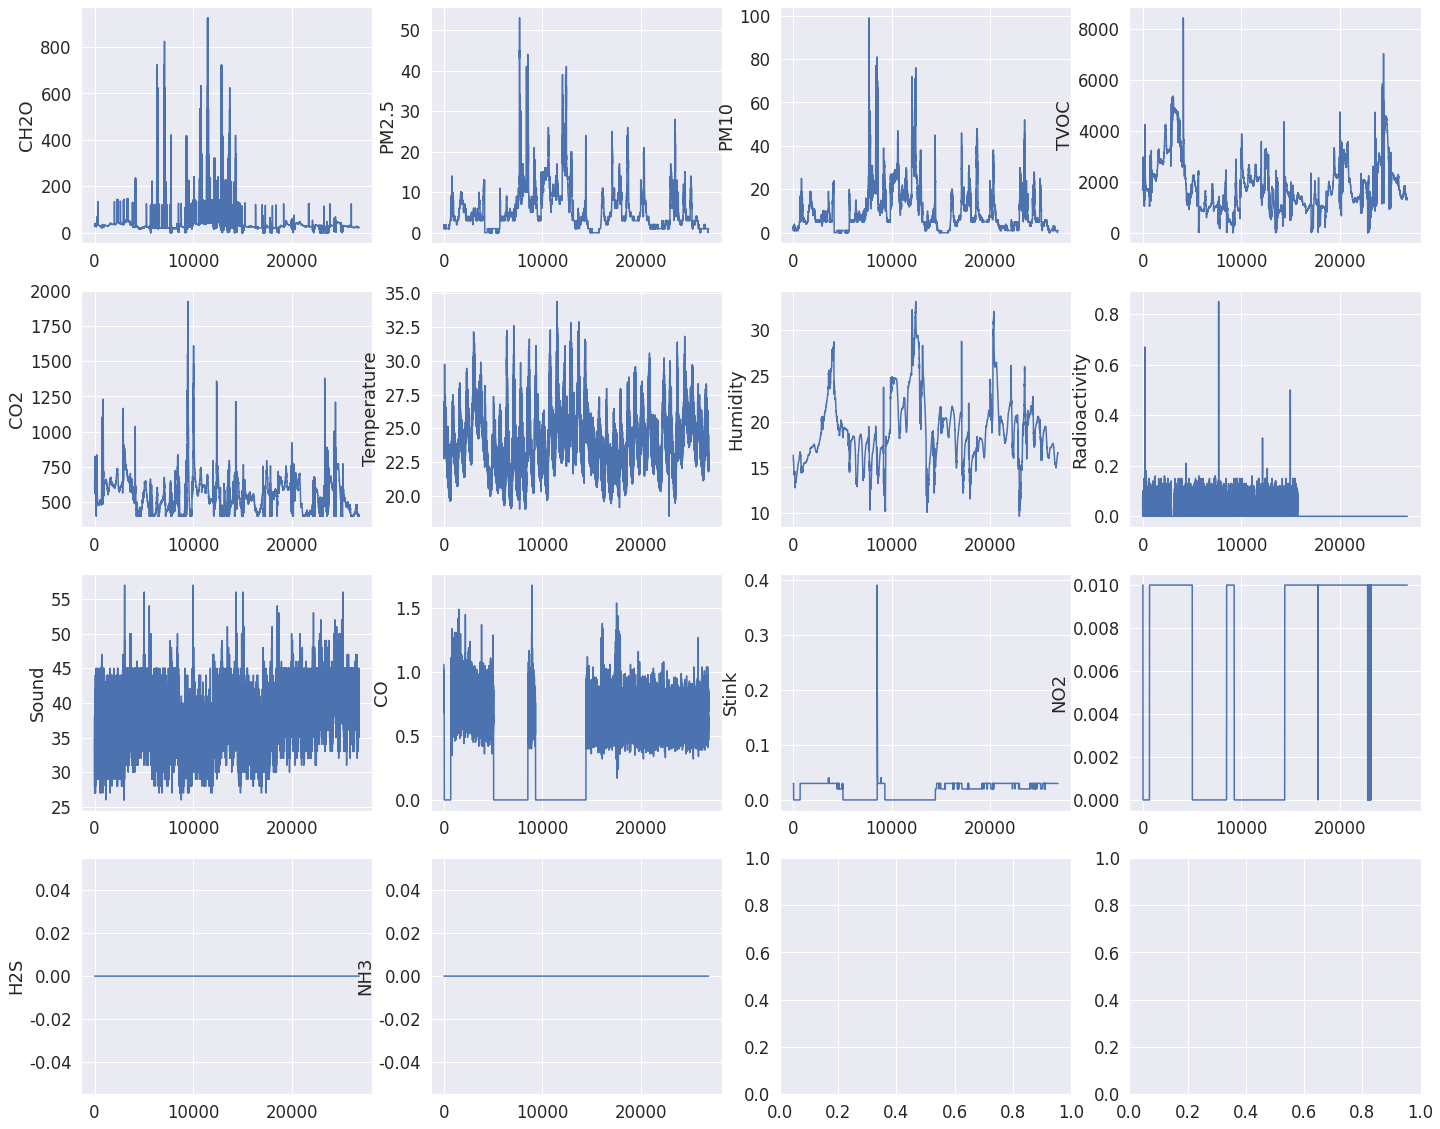

In [ ]:
subplots(device11,device11.columns[3:],4,4)

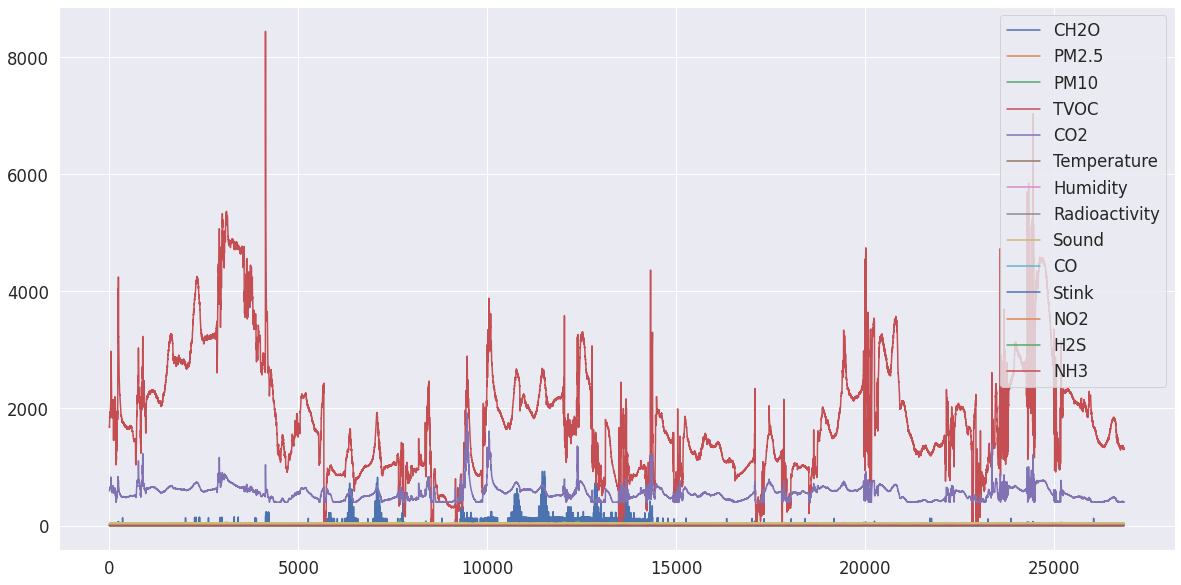

In [ ]:
lineplot(device11, device11.columns[3:])

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


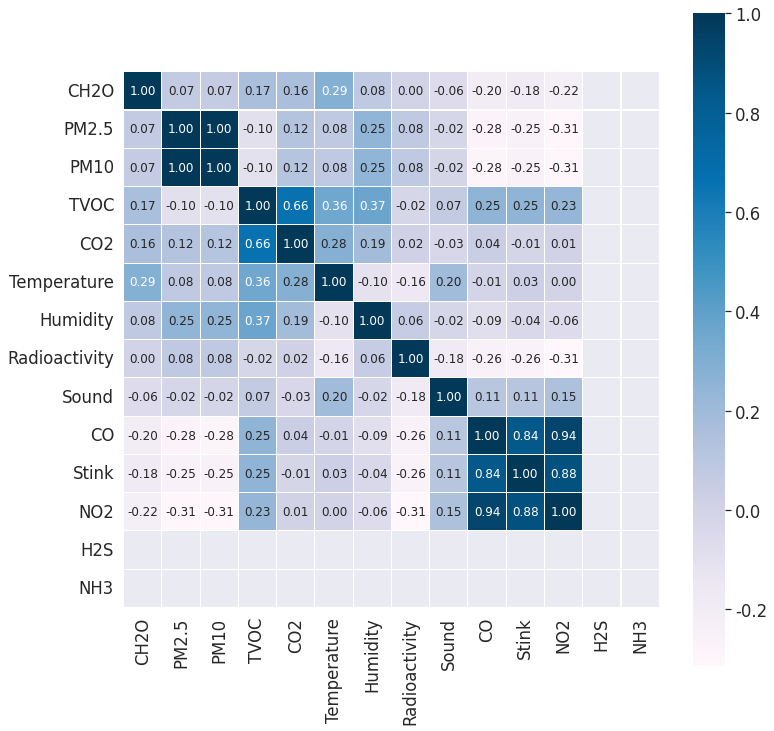

In [ ]:
corr_matrix(device11, device11.columns[3:])

### Device 16

In [ ]:
print(device16.shape)
device16.head()

(31591, 17)


,DeviceName,EntityId,TsYMD,CH2O,PM2.5,PM10,TVOC,CO2,Temperature,Humidity,Radioactivity,Sound,CO,Stink,NO2,H2S,NH3
0,Device 10000016,08228f50-144e-11ec-80c8-b1d8e607054f,2022-04-01 08:35:52,46.0,2.0,3.0,218.0,400.0,20.53,19.86,0.03,39.0,0.39,0.43,0.01,0.0,0.0
1,Device 10000016,08228f50-144e-11ec-80c8-b1d8e607054f,2022-04-01 08:37:52,46.0,2.0,3.0,218.0,400.0,20.53,19.85,0.03,35.0,0.42,0.43,0.01,0.0,0.0
2,Device 10000016,08228f50-144e-11ec-80c8-b1d8e607054f,2022-04-01 08:39:52,46.0,2.0,3.0,215.0,400.0,19.14,19.85,0.03,34.0,0.39,0.43,0.01,0.0,0.0
3,Device 10000016,08228f50-144e-11ec-80c8-b1d8e607054f,2022-04-01 08:41:52,45.0,2.0,3.0,215.0,400.0,20.51,19.85,0.06,36.0,0.25,0.43,0.01,0.0,0.0
4,Device 10000016,08228f50-144e-11ec-80c8-b1d8e607054f,2022-04-01 08:43:52,46.0,2.0,3.0,214.0,400.0,21.89,19.84,0.03,36.0,0.35,0.43,0.01,0.0,0.0


In [ ]:
device16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31591 entries, 0 to 31590
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     31591 non-null  object 
 1   EntityId       31591 non-null  object 
 2   TsYMD          31591 non-null  object 
 3   CH2O           31591 non-null  float64
 4   PM2.5          31591 non-null  float64
 5   PM10           31591 non-null  float64
 6   TVOC           31591 non-null  float64
 7   CO2            31591 non-null  float64
 8   Temperature    31591 non-null  float64
 9   Humidity       31591 non-null  float64
 10  Radioactivity  31591 non-null  float64
 11  Sound          31591 non-null  float64
 12  CO             31591 non-null  float64
 13  Stink          31591 non-null  float64
 14  NO2            31591 non-null  float64
 15  H2S            31591 non-null  float64
 16  NH3            31591 non-null  float64
dtypes: float64(14), object(3)
memory usage: 4.1+ MB


In [ ]:
device16.describe()

,CH2O,PM2.5,PM10,TVOC,CO2,Temperature,Humidity,Radioactivity,Sound,CO,Stink,NO2,H2S,NH3
count,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000,31591.000000
mean,48.285081,5.828907,9.967174,1719.719889,527.998924,23.187888,19.290544,0.015293,35.510019,0.177688,0.252847,0.005742,0.000032,0.175240
std,18.754226,5.030342,9.356082,1045.780245,116.377187,2.293207,3.450011,0.031207,4.599367,0.164155,0.222755,0.004945,0.005626,0.380261
min,8.000000,0.000000,0.000000,0.000000,400.000000,16.570000,10.890000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,3.000000,5.000000,979.000000,446.000000,21.580000,16.860000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,4.000000,7.000000,1452.000000,505.000000,22.950000,18.730000,0.000000,35.000000,0.230000,0.370000,0.010000,0.000000,0.000000
75%,60.000000,8.000000,13.000000,2182.000000,586.000000,24.600000,20.920000,0.030000,38.000000,0.310000,0.450000,0.010000,0.000000,0.000000
max,235.000000,54.000000,100.000000,8611.000000,1793.000000,33.570000,32.370000,1.870000,59.000000,0.870000,0.600000,0.010000,1.000000,2.000000


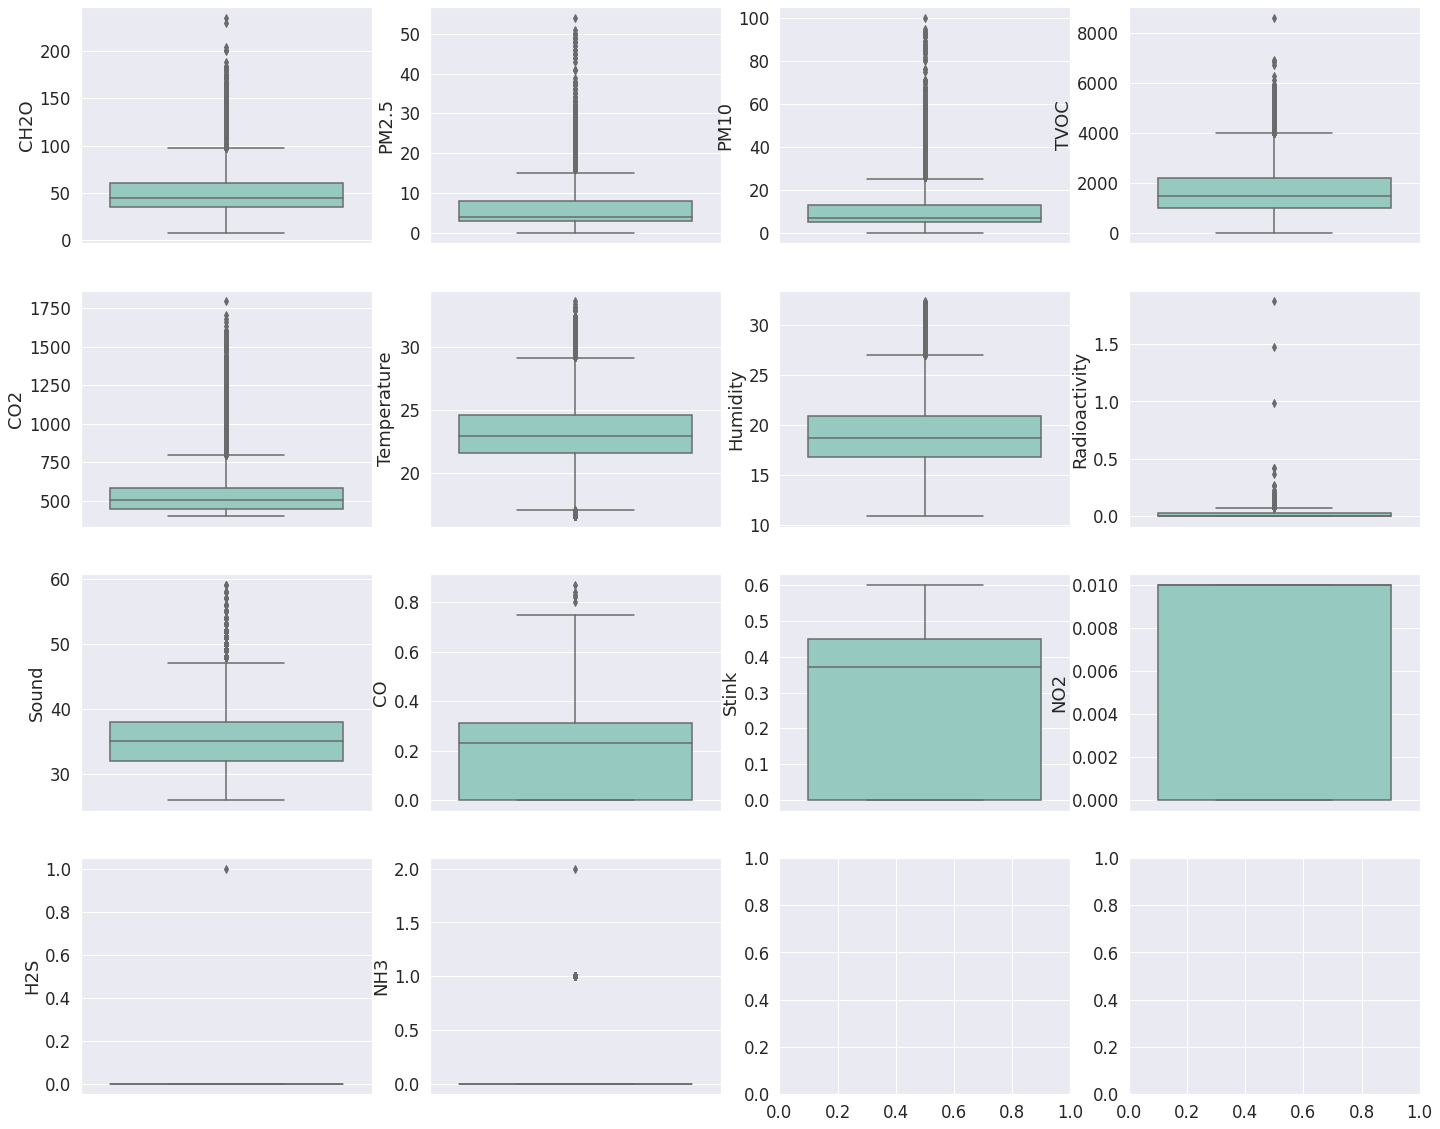

In [ ]:
boxplotEDA(device16,device16.columns[3:],4,4)

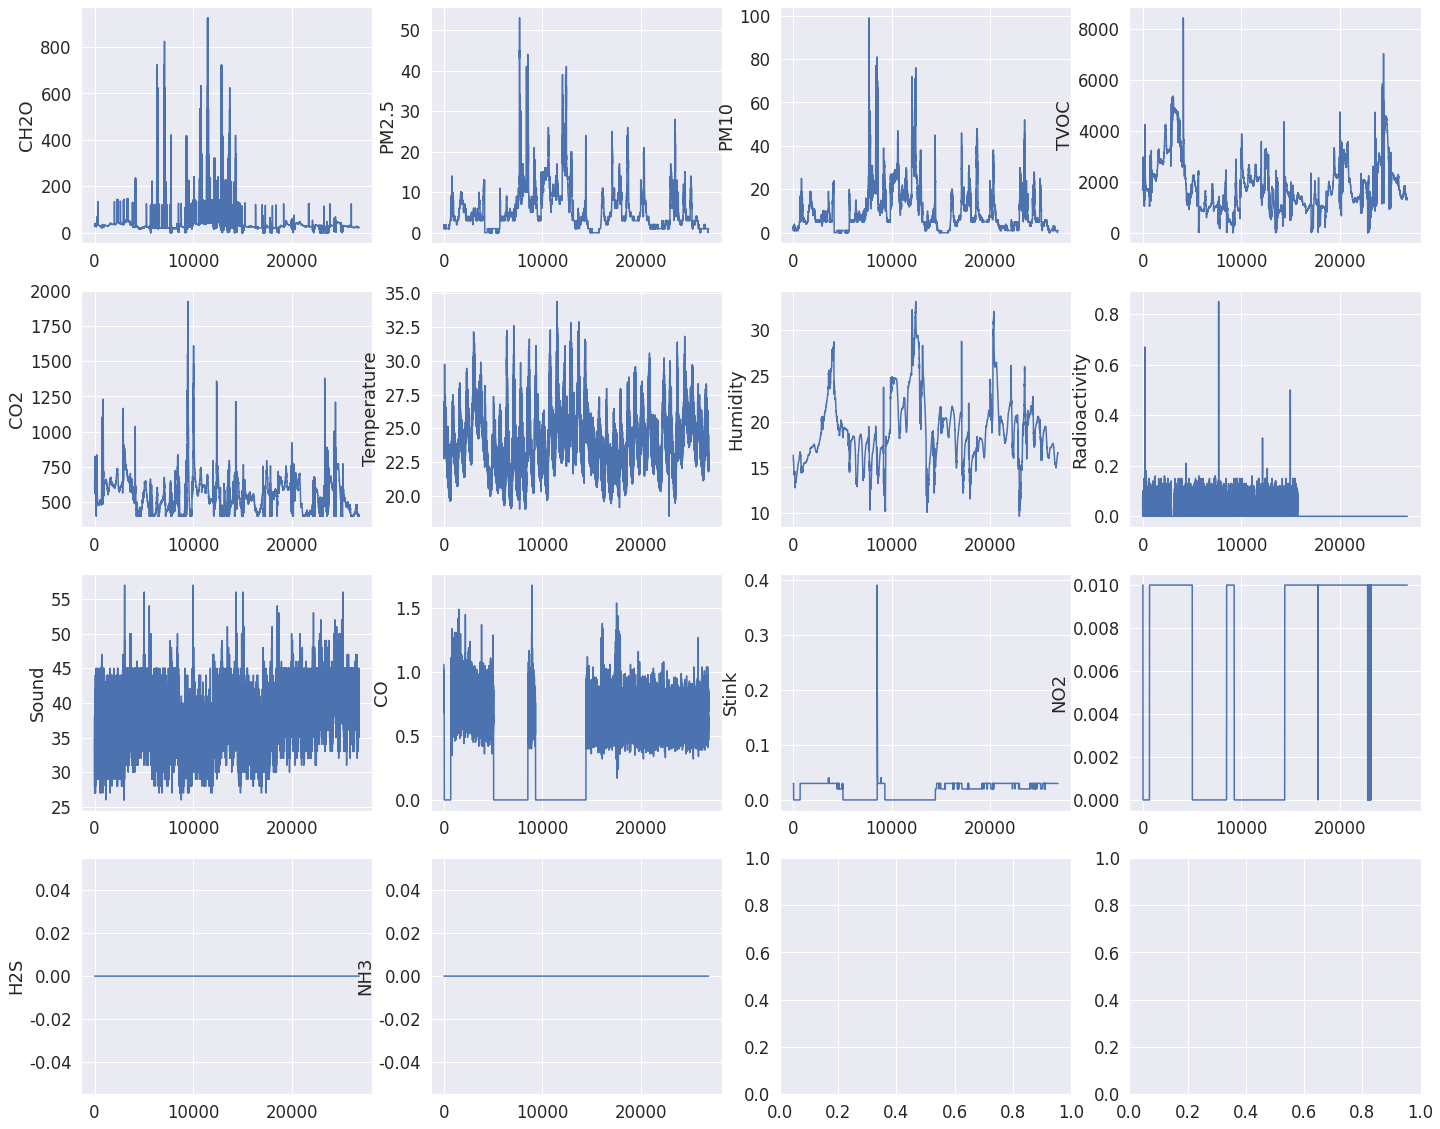

In [ ]:
subplots(device11,device11.columns[3:],4,4)

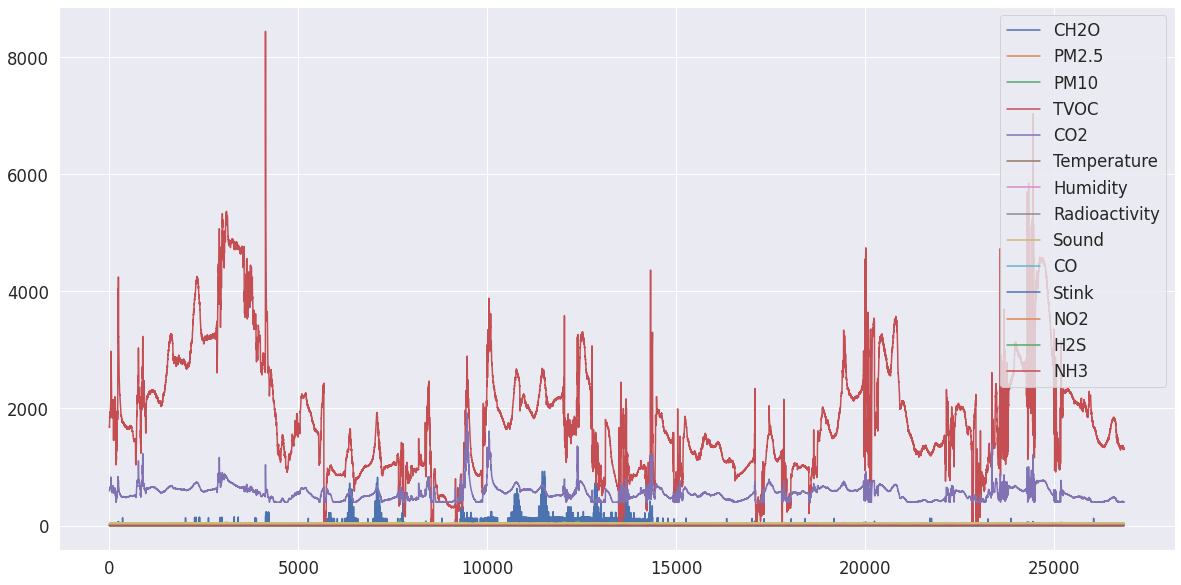

In [ ]:
lineplot(device11, device11.columns[3:])

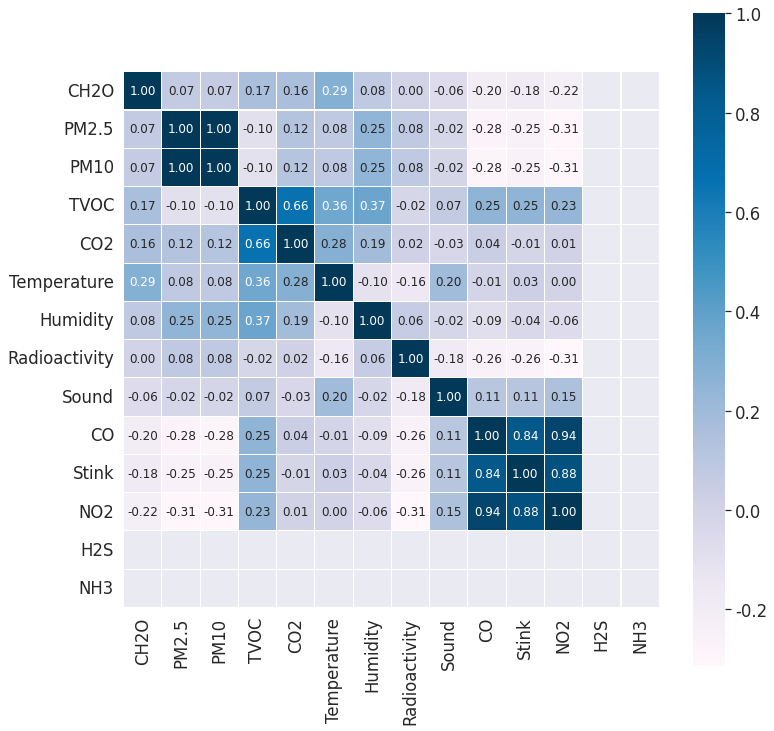

In [ ]:
corr_matrix(device11, device11.columns[3:])

## 2. Data Prprocessing

### Time Synchronization (2 min)

### Difference

### FFT(Fast Fourier Transform)